### ***Dataset***

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import cv2
from pycocotools.coco import COCO
import numpy as np
import torchvision.transforms as tr
import torchvision.transforms.functional as trf
import copy

In [2]:
class CocoDataset(Dataset):
    def __init__(self, root, jsonfile, train=True):
        self.root = root
        self.coco = COCO(jsonfile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.img_sizes = [416, 512, 640]
        self.train =train
        
        

    def _load_image(self, id):
        path = self.coco.loadImgs(id)[0]["file_name"]
        return np.array(Image.open(os.path.join(self.root, path)).convert("RGB"))
    

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id),)
        return image, targets
    

    
    

    def __getitem__(self, idx):
        
        image = self._load_image(idx)
        target = self._load_target(idx)
        
        targets = {}
        targets["boxes"] = torch.tensor([item['bbox'] for item in target], dtype=torch.float32)
        targets["labels"] = torch.tensor([item['category_id'] for item in target])

        boxes = []
        labels = []
        for i in range(len(targets["boxes"])):
            if (targets["boxes"][i][2] > 1.0) and (targets["boxes"][i][3] > 1.0) :
                boxes.append(targets["boxes"][i].numpy().tolist())
                labels.append(targets["labels"][i])

        targets["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        targets["labels"] = torch.tensor(labels)
        del boxes, labels

        
        if targets["boxes"].numel() > 0:
            targets["area"] = targets["boxes"][..., 2] * targets["boxes"][..., 3]
            targets["boxes"][..., 2] += targets["boxes"][..., 0]
            targets["boxes"][..., 3] += targets["boxes"][..., 1]
            targets["image_id"] = torch.tensor(target[0]["image_id"],dtype=torch.int64)
            targets["iscrowd"] = torch.tensor([item["iscrowd"] for item in target],dtype=torch.int64)
            

        else :
            targets["boxes"] = torch.zeros((0,4),dtype=torch.float32)
            targets["area"] = torch.zeros((0), dtype=torch.float32)
            targets["labels"] = torch.zeros((0),dtype=torch.int64)
            targets["image_id"] = torch.tensor([idx],dtype=torch.int64)
            targets["iscrowd"] = torch.zeros((0 ),dtype=torch.int64)

        image = trf.to_tensor(image)
        return image, targets

        

        
    
    def __len__(self):
        return len(self.ids)

In [3]:
def new_concat(batch):
  return tuple(zip(*batch))

In [4]:
trainset = CocoDataset(root="./datasets/screenshots/train/", jsonfile="./datasets/screenshots/annotations/instances_train.json", train=True)
testset = CocoDataset(root="./datasets/screenshots/valid", jsonfile="./datasets/screenshots/annotations/instances_valid.json", train=False)
trainloader = DataLoader(trainset, batch_size=1, shuffle=True, collate_fn=new_concat)
testloader = DataLoader(testset, batch_size=1, shuffle=True, collate_fn=new_concat) 

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [5]:
trainset[4][1]

{'boxes': tensor([[   7.,   10.,  186.,   45.],
         [  16.,   21.,   36.,   39.],
         [   7.,   10.,   45.,   50.],
         [  52.,   15.,  149.,   45.],
         [  52.,    5.,  213.,   55.],
         [ 150.,   19.,  163.,   33.],
         [ 118.,   33.,  196.,   44.],
         [ 579.,   15.,  713.,   29.],
         [ 570.,    6.,  713.,   56.],
         [ 579.,   28.,  688.,   44.],
         [ 723.,   15.,  775.,   29.],
         [ 714.,    6.,  834.,   56.],
         [ 723.,   29.,  834.,   49.],
         [ 844.,   15.,  888.,   29.],
         [ 835.,    6.,  906.,   56.],
         [ 844.,   28.,  884.,   44.],
         [ 955.,   28.,  999.,   44.],
         [ 907.,    6., 1020.,   56.],
         [ 917.,   17.,  956.,   43.],
         [ 231.,   14.,  348.,   47.],
         [ 532.,   20.,  554.,   41.],
         [ 520.,   10.,  566.,   50.],
         [ 369.,   11.,  521.,   49.],
         [ 571.,   72.,  714.,  102.],
         [ 570.,   71.,  715.,  104.],
         [ 559.,

In [6]:
import cv2
import matplotlib.pyplot as plt

In [7]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        if category_id == 0:
            continue
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(768, 1024, 3)
[[  48.   39.   65.   57.]
 [  48.   27.  130.   69.]
 [ 145.   38.  239.   58.]
 [ 129.   27.  276.   69.]
 [ 242.   39.  260.   57.]
 [ 291.   38.  382.   58.]
 [ 385.   39.  402.   57.]
 [ 275.   27.  402.   69.]
 [ 443.   24.  581.   66.]
 [ 443.   24.  581.   72.]
 [ 657.   38.  740.   58.]
 [ 641.   27.  756.   69.]
 [ 772.   38.  813.   58.]
 [ 756.   27.  829.   69.]
 [ 846.   39.  959.   56.]
 [ 829.   32.  976.   64.]
 [   0.    0. 1024.  608.]
 [   0.    0. 1024.  608.]
 [  48.  158.  699.  254.]
 [  48.  270.  699.  302.]
 [  48.  334.  244.  386.]
 [  48.  475. 1024.  496.]
 [ 322.  505.  343.  762.]
 [  48.  505.  976.  762.]
 [ 389.  541.  734.  558.]
 [ 389.  573.  734.  638.]
 [ 389.  653.  734.  726.]
 [ 781.  605.  928.  646.]]
tensor([5, 1, 8, 1, 5, 8, 5, 1, 5, 1, 8, 1, 8, 1, 8, 1, 5, 5, 3, 8, 1, 8, 5, 1,
        8, 8, 7, 8])
['elements', 'button', 'field', 'heading', 'iframe', 'image', 'label', 'link', 'text']


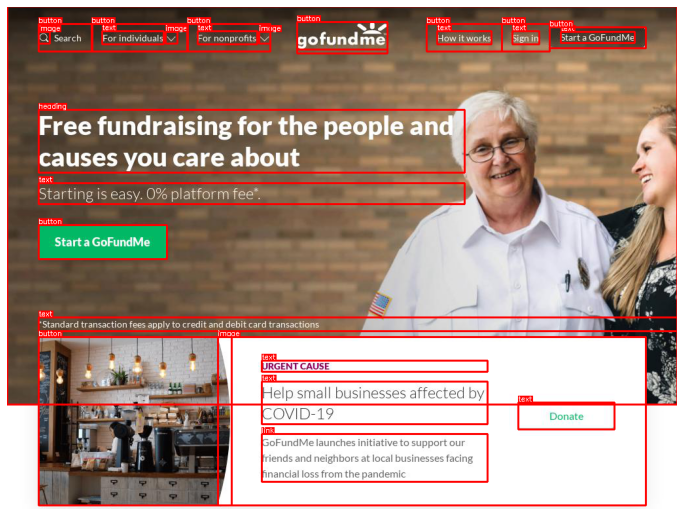

In [8]:
batchtrain = next(iter(trainloader))

image = batchtrain[0][0].permute(1, 2, 0).numpy()
print(image.shape)

bboxes = batchtrain[1][0]['boxes'].view(-1, 4).numpy()
print(bboxes)

category_ids = batchtrain[1][0]['labels'].squeeze().view(-1)
print(category_ids)

cats = trainset.coco.loadCats(trainset.coco.getCatIds())
category_id_to_name = [cat['name'] for cat in cats]
print(category_id_to_name)


visualize(image, bboxes, category_ids.tolist(), category_id_to_name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(768, 1024, 3)
[[  17.   35.   91.   47.]
 [  17.   35.   91.   47.]
 [ 161.   36.  192.   48.]
 [ 217.   36.  266.   48.]
 [ 290.   36.  370.   48.]
 [ 395.   36.  451.   48.]
 [ 475.   36.  527.   48.]
 [ 552.   36.  582.   48.]
 [ 688.   36.  723.   48.]
 [ 747.   36.  784.   48.]
 [ 809.   36.  851.   48.]
 [ 919.   31.  939.   51.]
 [ 919.    0.  939.   80.]
 [ 948.   31.  968.   51.]
 [ 948.    0.  968.   80.]
 [ 977.   31.  997.   51.]
 [ 977.    0.  997.   80.]
 [  62.  106.  962.  125.]
 [ 404.  127.  513.  145.]
 [ 513.  126.  533.  145.]
 [ 533.  127.  620.  145.]
 [   0.  203. 1024.  715.]
 [   0.  171. 1024.  747.]
 [  83.  242.  941.  311.]
 [ 385.  330.  480.  346.]
 [ 479.  327.  489.  341.]
 [ 488.  330.  639.  346.]
 [ 417.  380.  489.  398.]
 [ 514.  374.  607.  404.]
 [   0.  436.   46.  482.]
 [ 978.  436. 1024.  482.]
 [ 319.  692.  401.  712.]
 [ 319.  692.  401.  711.]
 [ 411.  692.  493.  712.]
 [ 411.  692.  493.  711.]
 [ 504.  680.  586.  712.]
 [ 504.  680.

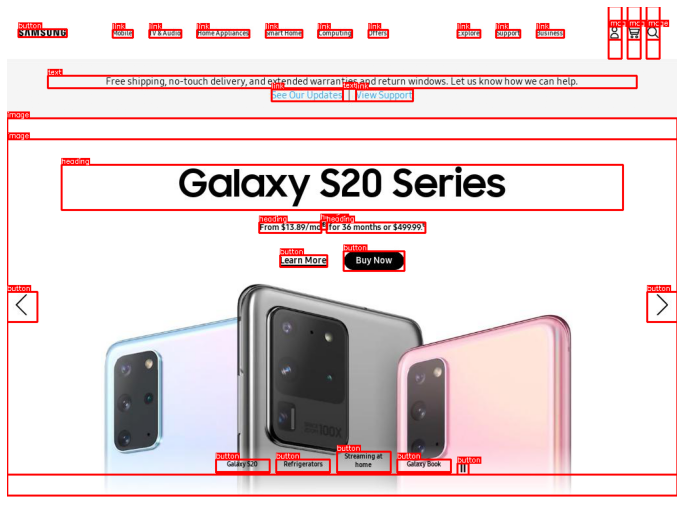

In [9]:
batchtest = next(iter(testloader))

image = batchtest[0][0].permute(1, 2, 0).numpy()
print(image.shape)

bboxes = batchtest[1][0]['boxes'].view(-1, 4).numpy()
print(bboxes)

category_ids = batchtest[1][0]['labels'].squeeze().view(-1)
print(category_ids)

cats = testset.coco.loadCats(testset.coco.getCatIds())
category_id_to_name = [cat['name'] for cat in cats]
print(category_id_to_name)

visualize(image, bboxes, category_ids.tolist(), category_id_to_name)

### ***Model***

In [10]:
!pip install timm
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision
import math

from collections import OrderedDict
from torchinfo import summary


device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

E:\Users\Kosar 37638090\anaconda3\lib\site-packages\apex\pyprof\__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [11]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/1000000

In [12]:
class CspDarknet53(nn.Module):
    def _replace_layers(self, model, old, new):
        for n, module in model.named_children():
            if len(list(module.children())) > 0:
                self._replace_layers(module, old, new)

            if isinstance(module, old):
                setattr(model, n, new)

    def __init__(self):
        super(CspDarknet53, self).__init__()
        net = timm.create_model("cspresnext50", pretrained=True)
        self._replace_layers(net, nn.LeakyReLU, nn.Mish(inplace = True))
        self.stem = net.stem
        self.stages = net.stages
        self.out_channels_list = [256, 512, 1024]
        del net
    def forward(self, x):
        outputs = OrderedDict()
        x = self.stem(x)
        x = self.stages[0](x)
        outputs[0] = self.stages[1](x)
        outputs[1] = self.stages[2](outputs[0])
        outputs[2] = self.stages[3](outputs[1])
        return outputs

In [13]:
net = CspDarknet53()

In [14]:
print([(k, v.shape) for k, v in net(torch.randn(1, 3, 608, 608)).items()])

[(0, torch.Size([1, 512, 76, 76])), (1, torch.Size([1, 1024, 38, 38])), (2, torch.Size([1, 2048, 19, 19]))]


In [15]:
summary(net, (8, 3, 608, 608), device="cpu")

Layer (type:depth-idx)                                  Output Shape              Param #
CspDarknet53                                            --                        --
├─Sequential: 1-1                                       [8, 64, 152, 152]         --
│    └─ConvBnAct: 2-1                                   [8, 64, 304, 304]         --
│    │    └─Conv2d: 3-1                                 [8, 64, 304, 304]         9,408
│    │    └─BatchNormAct2d: 3-2                         [8, 64, 304, 304]         128
│    └─MaxPool2d: 2-2                                   [8, 64, 152, 152]         --
├─Sequential: 1                                         --                        --
│    └─CrossStage: 2-3                                  [8, 256, 152, 152]        --
│    │    └─ConvBnAct: 3-3                              [8, 256, 152, 152]        16,896
│    │    └─Sequential: 3-4                             [8, 128, 152, 152]        114,432
│    │    └─ConvBnAct: 3-5                     

In [16]:
count_parameters(net)

18.520896

### ***Training***

In [17]:
!git clone https://github.com/pytorch/vision.git
import sys  
sys.path.insert(0, './vision/references/detection/')

In [18]:
from engine import train_one_epoch, evaluate
import utils

In [19]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import sys
from tqdm.notebook import tqdm
import os
from torch.utils.tensorboard import SummaryWriter
import datetime
import apex.amp as amp
import torchvision

date = datetime.datetime.now()


In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [21]:
backbone = CspDarknet53()
net = torchvision.models.detection.fcos_resnet50_fpn(pretrained=True)
net.backbone.body = backbone
# net.backbone.fpn = torchvision.ops.feature_pyramid_network.FeaturePyramidNetwork([256, 512, 1024], 256, extra_blocks=torchvision.ops.feature_pyramid_network.LastLevelP6P7(256, 256))
# net.anchor_generator = torchvision.models.detection.anchor_utils.AnchorGenerator(sizes=((8,), (16,), (32,)), aspect_ratios=((1.0,),) * 3)
net.transform = torchvision.models.detection.transform.GeneralizedRCNNTransform(512, 640, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], size_divisible=128)
net.head = torchvision.models.detection.fcos.FCOSHead(in_channels=256, num_classes=9, num_anchors=1, num_convs=4)
net = net.to(device)


In [22]:
count_parameters(net)

27.146574

In [23]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20000)

In [26]:
ACCUM_ITER = 8
BATCH_SIZE = 32
NAME = "Retinanet"

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE // ACCUM_ITER, shuffle=True, collate_fn=new_concat)
testloader = DataLoader(testset, batch_size=BATCH_SIZE // ACCUM_ITER, shuffle=True, collate_fn=new_concat) 
writer = SummaryWriter(f"./runs/{NAME}-{date.year}_{date.month}_{date.day}-{date.hour}_{date.minute}_{date.second}")

def train(epoch):
    loss_total = AverageMeter()
    net.train()
    
    loop = tqdm(trainloader, total = len(trainloader), leave = True)
    for batch_idx, (inputs, targets) in enumerate(loop):
        inputs = [image.to(device) for image in inputs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = net(inputs, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss = loss / ACCUM_ITER
        # with amp.scale_loss(loss, optimizer) as scaled_loss:
        loss.backward()
        if (batch_idx + 1) % ACCUM_ITER == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step() 
        loss_total.update(loss)
        loop.set_postfix(loss = loss_total.avg.item())
        
           
    writer.add_scalar('Loss/train', loss_total.avg.item(), epoch)
    # writer.add_scalar('MAP/train', meap, epoch)
    print(f'Train: Epoch:{epoch} Loss:{loss_total.avg:.4} ')

def valid(epoch, chekpoint=None):
    net.eval()
    eval = evaluate(net, testloader, device)
    meap = next(iter(eval.coco_eval.values())).stats[0]
    writer.add_scalar('MAP/valid', meap, epoch)
    print(f'Valid: Epoch:{epoch} MAP:{meap:.4}')
    if chekpoint is not None:
        chekpoint.save(net ,meap, f"{NAME}-{date.year}_{date.month}_{date.day}-{date.hour}_{date.minute}-MAP:{int(meap * 100)}", epoch)
    del eval, meap



class Checkpoint(object):
    def __init__(self):
        self.best_map = 0.
        self.folder = 'chekpoint'
        os.makedirs(self.folder, exist_ok=True)
    def save(self, model, meap, filename, epoch=-1):
        if meap > self.best_map:
            print('Saving checkpoint...')
            state = {
                'net': model.state_dict(),
                'map': meap,
                'epoch': epoch,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'amp': amp.state_dict() 
            }
            path = os.path.join(os.path.abspath(self.folder), filename + '.pth')
            torch.save(state, path)
            self.best_map = meap
    def load(self, net):
        pass

In [27]:
start, end = 0, 1
ckpt = Checkpoint()
for epoch in range(start, end):
    print()
    print(f"Epoch : {epoch}")
    print("="*100)
    train(epoch)
    # valid(epoch, ckpt)
    
    


Epoch : 0


  0%|          | 0/422 [00:00<?, ?it/s]

Train: Epoch:0 Loss:4.226 
